1. <a href='#1'>Ручная модель скорринга. </a>

2. <a href='#2'>Логистическая регрессия. </a>

3. <a href='#3'>Логистическая регрессия по изначальным данным. </a>

4. <a href='#4'>CatBoost Классификатор. </a>


### 1. РУЧНАЯ МОДЕЛЬ СКОРРИНГА <a id='1'></a>

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/DATASETS/Яндекс_датасеты/1 Банк/1_Проект_банк_кредиты.csv')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
df.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
df = df.dropna()

In [6]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [7]:
df['children'] = abs(df['children'])

In [8]:
test = df.sample(frac=0.2, random_state=42).copy()

In [9]:
train = df[~df.index.isin(test.index)].copy()

In [10]:
len(train) + len(test) - len(df)

0

In [11]:
train.head(1)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля


In [12]:
train.groupby('children').agg(count = ('debt', 'count'), mean = ('debt' , 'mean'))

,count,mean
children,,
0,10157,0.075022
1,3521,0.097700
2,1492,0.091823
3,228,0.074561
4,27,0.111111
5,5,0.000000
20,51,0.078431


In [13]:
train['has_children'] = (train['children'] != 0) * 1

In [14]:
train.groupby('has_children').agg(count = ('debt', 'count'), mean = ('debt' , 'mean'))

,count,mean
has_children,,
0,10157,0.075022
1,5324,0.094853


In [15]:
train['education'] = train['education'].str.lower()
test['education'] = test['education'].str.lower()

In [16]:
train.groupby('education').agg(count = ('debt', 'count'), mean = ('debt' , 'mean'))

,count,mean
education,,
высшее,3790,0.054354
начальное,200,0.110000
неоконченное высшее,542,0.099631
среднее,10943,0.090012
ученая степень,6,0.000000


In [17]:
train['no_college'] = (~train['education'].isin(['высшее','ученая степень'])) * 1

In [18]:
train.groupby('no_college').agg(count = ('debt', 'count'), mean = ('debt' , 'mean'))

,count,mean
no_college,,
0,3796,0.054268
1,11685,0.090800


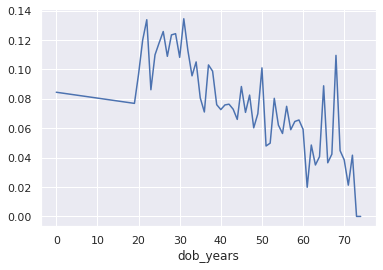

In [19]:
train.groupby('dob_years')['debt'].mean().plot()

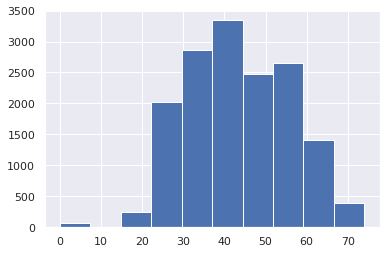

In [20]:
train['dob_years'].hist()

In [21]:
train['dob_years_norm'] = 1 - train['dob_years'] / train['dob_years'].max()

In [22]:
train['score'] = train['has_children'] + train['no_college'] + train['dob_years_norm']

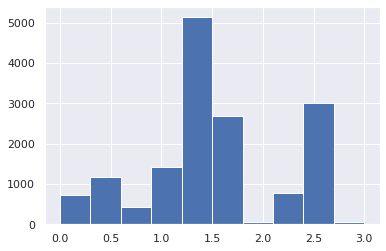

In [23]:
train['score'].hist()

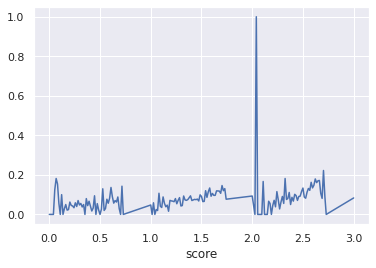

In [24]:
train.groupby('score')['debt'].mean().plot()

In [25]:
train['score_round'] = train['score'].round()

In [26]:
train.groupby('score_round').agg(count = ('debt', 'count'), mean = ('debt', 'mean'))

,count,mean
score_round,,
0.0,1516,0.043536
1.0,7367,0.067599
2.0,4770,0.097484
3.0,1828,0.130197


In [27]:
train['score_norm'] = train['score'] / train['score'].max()

In [28]:
train.groupby('score_norm').agg(count = ('debt', 'count'), mean = ('debt', 'mean'))

,count,mean
score_norm,,
0.000000,1,0.000000
0.009009,6,0.000000
0.013514,6,0.000000
0.018018,8,0.125000
0.022523,11,0.181818
...,...,...
0.896396,37,0.081081
0.900901,18,0.222222
0.905405,11,0.090909


In [29]:
!pip install scikit-plot

In [30]:
from scikitplot.helpers import cumulative_gain_curve

In [31]:
t = pd.DataFrame(cumulative_gain_curve(train['debt'], train['score_norm'])).T

In [32]:
t

,0,1
0,0.000000,0.0
1,0.000065,0.0
2,0.000129,0.0
3,0.000194,0.0
4,0.000258,0.0
...,...,...
15477,0.999742,1.0
15478,0.999806,1.0
15479,0.999871,1.0
15480,0.999935,1.0


In [33]:
t['random'] = t[0]

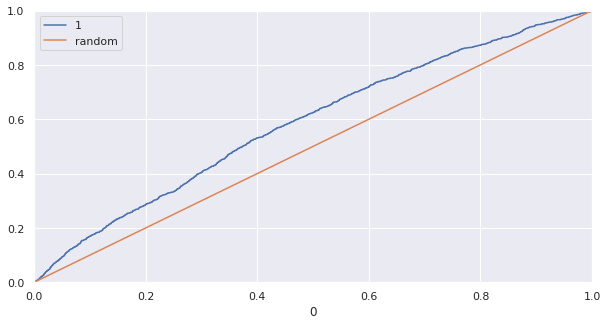

In [34]:
t.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

In [35]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [36]:
auc_train_manual = auc(t[0],t[1])

In [37]:
auc_train_manual

0.5861506685869539

In [38]:
roc_auc_score(train['debt'], train['score_norm'])

0.5938913900265521

In [39]:
test['has_children'] = (test['children'] != 0) * 1
test['no_colledge'] = (~test['education'].isin(['высшее','ученая степень'])) * 1
test['dob_years_norm'] = 1 - test['dob_years'] / test['dob_years'].max()
test['score'] = test[['has_children','no_colledge','dob_years_norm']].sum(axis=1)
test['score_norm'] = test['score'] / test['score'].max()

In [40]:
tt = pd.DataFrame(cumulative_gain_curve(test['debt'],test['score_norm'])).T

In [41]:
tt

,0,1
0,0.000000,0.000000
1,0.000258,0.003289
2,0.000517,0.003289
3,0.000775,0.006579
4,0.001034,0.006579
...,...,...
3866,0.998966,1.000000
3867,0.999225,1.000000
3868,0.999483,1.000000
3869,0.999742,1.000000


In [42]:
tt['random'] = tt[0]

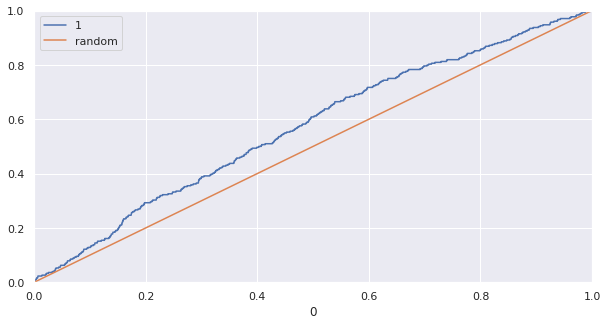

In [43]:
tt.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

In [44]:
auc_test_manual = auc(tt[0],tt[1])

In [45]:
auc_test_manual

0.5696008431932544

In [46]:
roc_auc_score(test['debt'], test['score_norm'])

0.5754032972223042

### 2. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ <a id='2'></a>

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
Lr = LogisticRegression()

In [49]:
train.head(2)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children,no_college,dob_years_norm,score,score_round,score_norm
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,1,1,0.513514,2.513514,3.0,0.837838
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,0,1,0.554054,1.554054,2.0,0.518018


In [50]:
Lr.fit(train[['has_children','no_college','dob_years_norm']], train['debt'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
Lr.predict_proba(train[['has_children','no_college','dob_years_norm']])[:,1]
# вероятность для каждого id быть классом 1 - т.е. иметь debt(лежит в 1 столбце, в 0 столбце вероятность быть классом 0)

array([0.11009527, 0.10685361, 0.0705544 , ..., 0.05231973, 0.1057167 ,
       0.10149241])

In [52]:
train['lr_debt_pred'] = Lr.predict_proba(train[['has_children','no_college','dob_years_norm']])[:,1]

In [53]:
roc_auc_score(train['debt'], train['lr_debt_pred'])

0.610634889909778

In [54]:
lr_t = pd.DataFrame(cumulative_gain_curve(train['debt'],train['lr_debt_pred'])).T

In [55]:
lr_t['random'] = lr_t[0]

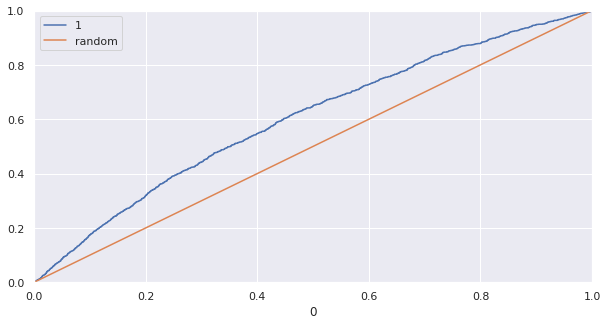

In [56]:
lr_t.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1) )

In [57]:
auc_train_lr = auc(lr_t[0],lr_t[1])

In [58]:
auc_train_lr

0.6015695232901782

In [59]:
test.head(1)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children,no_colledge,dob_years_norm,score,score_norm
1607,0,-4144.711272,49,высшее,0,женат / замужем,0,M,компаньон,0,264985.908498,свой автомобиль,0,0,0.346667,0.346667,0.115556


In [60]:
test['lr_debt_pred'] = Lr.predict_proba(test[['has_children','no_colledge','dob_years_norm']])[:,1]

In [61]:
roc_auc_score(test['debt'], test['lr_debt_pred'])

0.5938625394810638

In [62]:
lr_tt = pd.DataFrame(cumulative_gain_curve(test['debt'],test['lr_debt_pred'])).T

In [63]:
lr_tt['random'] = lr_tt[0]

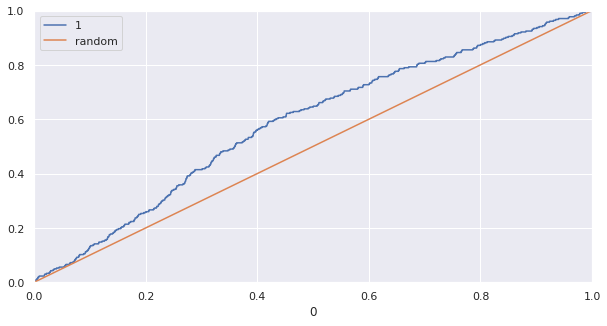

In [64]:
lr_tt.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1) )

In [65]:
auc_test_lr = auc(lr_tt[0],lr_tt[1])

In [66]:
auc_test_lr

0.5862700598395213

### 3. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ПО ИЗНАЧАЛЬНЫМ ДАННЫМ <a id='3'></a>

In [67]:
cat_features = ['education']
train = pd.get_dummies(train, columns=cat_features)

In [68]:
train.head(1)

,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children,no_college,dob_years_norm,score,score_round,score_norm,lr_debt_pred,education_высшее,education_начальное,education_неоконченное высшее,education_среднее,education_ученая степень
1,1,-4024.803754,36,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,1,1,0.513514,2.513514,3.0,0.837838,0.110095,0,0,0,1,0


In [69]:
cols = ['children','dob_years', 'education_высшее', 'education_начальное', 
        'education_неоконченное высшее','education_среднее']
Lr.fit(train[cols], train['debt'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
Lr.predict_proba(train[cols])[:,1]
# вероятность для каждого id быть классом 1 - т.е. иметь debt(лежит в 1 столбце, в 0 столбце вероятность быть классом 0)

array([0.10534225, 0.11267128, 0.07139166, ..., 0.05133214, 0.10070614,
       0.09623288])

In [71]:
train['lr_debt_pred_2nd'] = Lr.predict_proba(train[cols])[:,1]

In [72]:
roc_auc_score(train['debt'], train['lr_debt_pred_2nd'])

0.6103166070469336

In [73]:
lr_t_2nd = pd.DataFrame(cumulative_gain_curve(train['debt'],train['lr_debt_pred_2nd'])).T

In [74]:
lr_t_2nd['random'] = lr_t_2nd[0]

In [75]:
auc_train_lr_2nd = auc(lr_t_2nd[0],lr_t_2nd[1])

auc_train_lr_2nd

0.6012828975325152

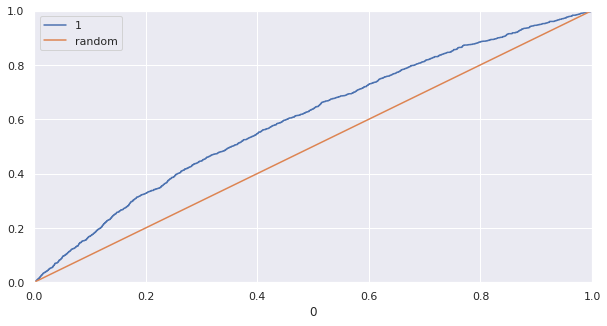

In [76]:
lr_t_2nd.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

In [77]:
cat_features = ['education']
test = pd.get_dummies(test, columns=cat_features)

In [78]:
test.head(1)

,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children,no_colledge,dob_years_norm,score,score_norm,lr_debt_pred,education_высшее,education_начальное,education_неоконченное высшее,education_среднее
1607,0,-4144.711272,49,0,женат / замужем,0,M,компаньон,0,264985.908498,свой автомобиль,0,0,0.346667,0.346667,0.115556,0.042897,1,0,0,0


In [79]:
test['lr_debt_pred_2nd'] = Lr.predict_proba(test[cols])[:,1]

In [80]:
roc_auc_score(test['debt'], test['lr_debt_pred_2nd'])

0.5970191796794285

In [81]:
lr_tt_2nd = pd.DataFrame(cumulative_gain_curve(test['debt'],test['lr_debt_pred_2nd'])).T

In [82]:
lr_tt_2nd['random'] = lr_tt_2nd[0]

In [83]:
auc_test_lr_2nd = auc(lr_tt_2nd[0],lr_tt_2nd[1])

auc_test_lr_2nd

0.589250135998912

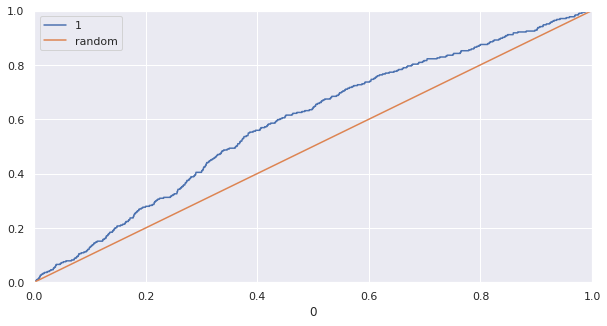

In [84]:
lr_tt_2nd.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

### 4. CATBOOST КЛАССИФИКАТОР <a id='4'></a>

In [85]:
!pip install catboost

     |████████████████████████████████| 66.2MB 70kB/s 


In [86]:
from catboost import CatBoostClassifier
# Initialize data
cat_features = [0, 1]
train_data = [["a", "b", 1, 4, 5, 6],
              ["a", "b", 4, 5, 6, 7],
              ["c", "d", 30, 40, 50, 60]]
train_labels = [1, 1, -1]
eval_data = [["a", "b", 2, 4, 6, 8],
             ["a", "d", 1, 4, 50, 60]]

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
# Fit model
model.fit(train_data, train_labels, cat_features)
# Get predicted classes
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

0:	learn: 0.5800330	total: 48.2ms	remaining: 48.2ms
1:	learn: 0.4935379	total: 48.7ms	remaining: 0us


In [87]:
train.head(1)

,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children,no_college,dob_years_norm,score,score_round,score_norm,lr_debt_pred,education_высшее,education_начальное,education_неоконченное высшее,education_среднее,education_ученая степень,lr_debt_pred_2nd
1,1,-4024.803754,36,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,1,1,0.513514,2.513514,3.0,0.837838,0.110095,0,0,0,1,0,0.105342


In [88]:
train.education_id.unique()

array([1, 0, 2, 3, 4])

In [89]:
X_col = ['children', 'dob_years', 'education_высшее','education_начальное',
         'education_неоконченное высшее','education_среднее']
y_col = ['debt']
cat_features1 = ['children','education']

In [90]:
model = CatBoostClassifier()

In [91]:
model.fit(train[X_col],train[y_col])

Learning rate set to 0.033188
0:	learn: 0.6599677	total: 5.93ms	remaining: 5.93s
1:	learn: 0.6294622	total: 11.8ms	remaining: 5.86s
2:	learn: 0.6016060	total: 17.5ms	remaining: 5.81s
3:	learn: 0.5753020	total: 23.4ms	remaining: 5.83s
4:	learn: 0.5513051	total: 29.9ms	remaining: 5.95s
5:	learn: 0.5296461	total: 35.3ms	remaining: 5.84s
6:	learn: 0.5092333	total: 40.4ms	remaining: 5.73s
7:	learn: 0.4908225	total: 45.6ms	remaining: 5.65s
8:	learn: 0.4736800	total: 51.5ms	remaining: 5.67s
9:	learn: 0.4585679	total: 56.6ms	remaining: 5.61s
10:	learn: 0.4441766	total: 61.3ms	remaining: 5.51s
11:	learn: 0.4309256	total: 67.4ms	remaining: 5.55s
12:	learn: 0.4189006	total: 73.4ms	remaining: 5.57s
13:	learn: 0.4077548	total: 86.1ms	remaining: 6.07s
14:	learn: 0.3977670	total: 93.2ms	remaining: 6.12s
15:	learn: 0.3885249	total: 99.1ms	remaining: 6.1s
16:	learn: 0.3798067	total: 105ms	remaining: 6.08s
17:	learn: 0.3719573	total: 111ms	remaining: 6.06s
18:	learn: 0.3646319	total: 117ms	remaining: 6.

In [92]:
train['cat_debt_pred'] = model.predict_proba(train[X_col])[:,1]

In [93]:
cat = pd.DataFrame(cumulative_gain_curve(train['debt'],train['cat_debt_pred'])).T

In [94]:
cat

,0,1
0,0.000000,0.000000
1,0.000065,0.000789
2,0.000129,0.001579
3,0.000194,0.002368
4,0.000258,0.003157
...,...,...
15477,0.999742,1.000000
15478,0.999806,1.000000
15479,0.999871,1.000000
15480,0.999935,1.000000


In [95]:
cat['random'] = cat[0]

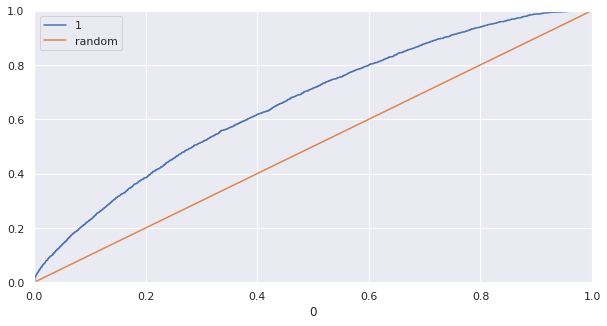

In [96]:
cat.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

In [97]:
auc_cat_train = auc(cat[0],cat[1])

auc_cat_train

0.6598615141803531

In [98]:
roc_auc_score(train['debt'], train['cat_debt_pred'])

0.6741062231851408

In [99]:
test['cat_debt_pred'] = model.predict_proba(test[X_col])[:,1]

In [100]:
cat_test = pd.DataFrame(cumulative_gain_curve(test['debt'],test['cat_debt_pred'])).T

In [101]:
cat_test

,0,1
0,0.000000,0.0
1,0.000258,0.0
2,0.000517,0.0
3,0.000775,0.0
4,0.001034,0.0
...,...,...
3866,0.998966,1.0
3867,0.999225,1.0
3868,0.999483,1.0
3869,0.999742,1.0


In [102]:
cat_test['random'] = cat_test[0]

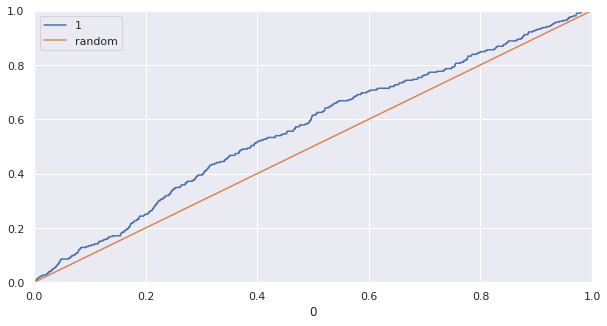

In [103]:
cat_test.plot(x=0, y=[1,'random'],figsize=(10,5),grid=True,xlim=(0,1),ylim=(0,1))

In [104]:
auc_cat_test = auc(cat_test[0],cat_test[1])

auc_cat_test

0.5640546375628995

In [105]:
roc_auc_score(test['debt'], test['cat_debt_pred'])

0.5696268854975353

In [106]:
print('Данные по ручному методу скорринга')
auc_train_manual,\
auc_test_manual,\
roc_auc_score(train['debt'], train['score_norm']),\
roc_auc_score(test['debt'], test['score_norm'])

Данные по ручному методу скорринга


(0.5861506685869539,
 0.5696008431932544,
 0.5938913900265521,
 0.5754032972223042)

In [107]:
print('Данные по логистической регрессии')
auc_train_lr,\
auc_test_lr,\
roc_auc_score(train['debt'], train['lr_debt_pred']),\
roc_auc_score(test['debt'], test['lr_debt_pred'])

Данные по логистической регрессии


(0.6015695232901782, 0.5862700598395213, 0.610634889909778, 0.5938625394810638)

In [108]:
print('Данные по логистической регрессии изначальных данных')
auc_train_lr_2nd,\
auc_test_lr_2nd,\
roc_auc_score(train['debt'], train['lr_debt_pred_2nd']),\
roc_auc_score(test['debt'], test['lr_debt_pred_2nd'])

Данные по логистической регрессии изначальных данных


(0.6012828975325152, 0.589250135998912, 0.6103166070469336, 0.5970191796794285)

In [109]:
print('Данные по catboost')
auc_cat_train,\
auc_cat_test,\
roc_auc_score(train['debt'], train['cat_debt_pred']),\
roc_auc_score(test['debt'], test['cat_debt_pred'])

Данные по catboost


(0.6598615141803531,
 0.5640546375628995,
 0.6741062231851408,
 0.5696268854975353)